# Archivo ya sustituido por k-means_obd

In [1]:
import sys, os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

#### Using PostgreSQL in python

In [3]:
os.system('python -m pip install dipy')
os.system('python -m pip install psycopg2')
os.system('python -m pip install scipy')

import psycopg2

In [4]:
# Importar contextily con conda 
# que no es más que otra forma de descargar mapas en forma de tiles de internet
import contextily as ctx
import geopy.distance #libreria para geocodificar

In [5]:
from shapely.geometry import LineString
from pyproj import Proj, transform



#------------------------------------------------------------------------------------
# Required by clustering class QuickBundles
#------------------------------------------------------------------------------------
import dipy 
from dipy.segment.metric import Metric
from dipy.segment.featurespeed import ResampleFeature
from dipy.segment.clustering import QuickBundles

In [6]:
class GPSDistance(Metric):
    def __init__(self):
        super().__init__(feature=ResampleFeature(nb_points=256))
        #self._geod = Geod(ellps='WGS84')

    def are_compatible(self, shape_1, shape_2):
        return len(shape_1) == len(shape_2)
    def dist(self, v1, v2):
        distances = [geopy.distance.distance([p[0][0],p[0][1]],[p[1][0],p[1][1]]).km for p in list(zip(v1,v2))]
        return np.mean(distances)/1000.0

In [7]:
# OpenStreetMap
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/{z}/{x}/{y}.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, source=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

d:\proyectos\python310\lib\site-packages\geopandas\io\sql.py:158: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


0    LINESTRING (-4.46440 36.71293, -4.46457 36.712...
1    LINESTRING (-4.45526 36.72348, -4.45620 36.721...
2    LINESTRING (-4.47320 36.71386, -4.47322 36.713...
3    LINESTRING (-4.47728 36.72257, -4.47734 36.722...
4    MULTILINESTRING ((-4.45526 36.71362, -4.45540 ...
Name: trayectos, dtype: geometry
Iniciando algoritmo
Numero de clusters,  9
Tengo 7  clusters validos


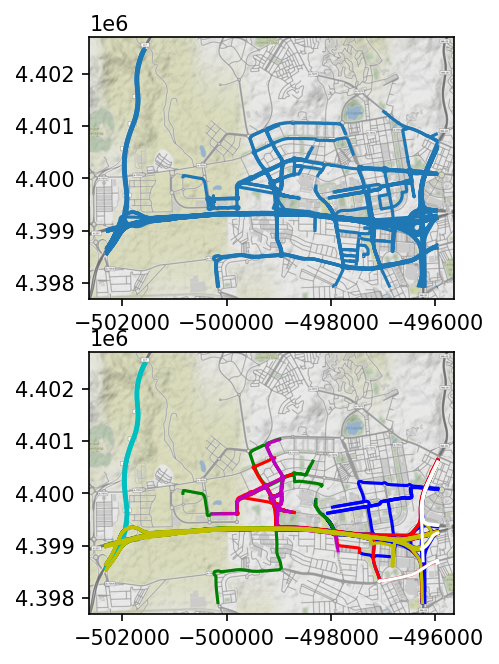

In [8]:
#----------------------------------------------
# Step 0: Draw maps 
#----------------------------------------------
#plt.ion() #interactive... continue after plot
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#base = world.plot(color='white', edgecolor='black')
fig = plt.figure( figsize=(8, 5), dpi=150) # create the canvas for plotting
ax1 = plt.subplot(2,1,1) 
ax2 = plt.subplot(2,1,2, sharex = ax1, sharey = ax1)


#----------------------------------------------
# Step 1: Stablish connection between python and postgresql and get some tracks (result)
#----------------------------------------------
conn = psycopg2.connect("dbname = 'mlearn' user = 'ml_aa00' host = 'obd.ac.uma.es' password = 'vc0910$$'")
#cur = conn.cursor()
sql="select * from candidatos"
#cur.execute(sql)
#result = cur.fetchone()
#cur.close()
result = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='trayectos', crs  ='epsg:4326')#.to_crs(epsg=3857)
conn.close()

#----------------------------------------------
# Step 2: Store tracks in a custon array, before using QuickBundles
#----------------------------------------------
result=result['trayectos']
result3857=result.to_crs(epsg=3857)
result3857.plot(ax=ax1)
add_basemap(ax1, zoom=15)
print(result.head())
listarray = []
#from shapely.ops import linemerge
for track in result:
    if track.geom_type == 'LineString':
        x,y = track.coords.xy
        listarray.append(np.transpose([x,y]))
    



#----------------------------------------------
# Step 3: Execute QuickBundles
#----------------------------------------------

print('Iniciando algoritmo')
metric=GPSDistance()
qb=QuickBundles(threshold=0.001,metric=metric)
clusters=qb.cluster(listarray)
print('Numero de clusters, ',len(clusters))

#----------------------------------------------
# Step 4: Read clusters from results and draw on map
#----------------------------------------------

outProj = Proj(init='epsg:3857')
inProj = Proj(init='epsg:4326')
color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
cnt=0
for i in range(0,len(clusters)):
    if len(clusters[i].indices) > 2:
        cnt=cnt+1
        for j in clusters[i].indices:
            lista=listarray[j]
            line =LineString(lista)
            x,y=transform(inProj,outProj,line.coords.xy[0],line.coords.xy[1])
            ax2.plot(x,y,color[i%8])
print("Tengo" ,cnt, " clusters validos")
add_basemap(ax2, zoom=15)
plt.show()